<a href="https://colab.research.google.com/github/KGL8/Code-for-Lab/blob/main/photon_through_deuteron_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pythreejs

from google.colab import output
output.enable_custom_widget_manager()
import numpy as np
import random
from pythreejs import *
import matplotlib.pyplot as plt

# Primitive elements

In [2]:
# create an instance of the line segment object
def ray(origin, direction, length, col):
  return Line(geometry=BufferGeometry(attributes={'position': BufferAttribute(array=np.array([origin, length * np.array(direction)]), normalized=False),}),material=LineBasicMaterial(color=col))

In [3]:
# create an instance of the box object
def point(position, col, size):
  return Points(geometry=BufferGeometry(attributes={"position": BufferAttribute(np.array([position]), normalized=False)}),
                material=PointsMaterial(color=col, size=size, sizeAttenuation=False))

In [4]:
# create an instance of the box object
def box(width, height, depth, position, col):
  box_geometry = BoxBufferGeometry(width=width, height=height, depth=depth)

  box_material = MeshPhysicalMaterial(color=col, transparent=True, opacity=0.5)
  box_mesh = Mesh(geometry=box_geometry, material=box_material)

  wireframe_material = LineBasicMaterial(color='#ff7070',linewidth=2)
  wireframe = WireframeGeometry(box_geometry)
  wireframe_mesh = LineSegments(wireframe, wireframe_material)

  box_group = Group(children=[box_mesh, wireframe_mesh])
  box_group.position = position

  return box_group

# Helper fuctions

In [5]:
# spherical to cartesian
def sph_car(theta, phi, r=1):
  x = r * np.sin(phi) * np.cos(theta)
  y = r * np.sin(phi) * np.sin(theta)
  z = r * np.cos(phi)
  return np.array([x, y, z])

In [6]:
# entry and exit points for a ray through an axis-aligned box
def intersect_ray_box(ray_origin, ray_direction, box_min, box_max):
    tnear = float('-inf')
    tfar = float('inf')

    for i in range(3):
        if ray_direction[i] == 0:
            if ray_origin[i] < box_min[i] or ray_origin[i] > box_max[i]:
                return None, None
        else:
            t1 = (box_min[i] - ray_origin[i]) / ray_direction[i]
            t2 = (box_max[i] - ray_origin[i]) / ray_direction[i]

            if t1 > t2:
                t1, t2 = t2, t1

            if t1 > tnear:
                tnear = t1

            if t2 < tfar:
                tfar = t2

            if tnear > tfar:
                return None, None

            if tfar < 0:
                return None, None

    return ray_origin + ray_direction * tnear, ray_origin + ray_direction * tfar

In [7]:
# takes two numpy arrays
def angle_between_vectors(a, b):
    return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [36]:
# my mathematically precise distance piecewise; still gotta get top and bottom and set up the trigger intervals
# I am going to be filling in the mathematically precise functions of theta and phi to replace the rough ones
# for all, the only restrictions are that dir (or sph_car(theta,phi)) is normalized. This can be ignored.
def dist(side):
  if side == 'back':
    # a pure function in and of itself
    return depth/np.cos(phi)
  elif side == 'right':
    # \frac{-w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([-1,0,0]))))-origin/np.cos(phi)
  elif side == 'left':
    # \frac{w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([1,0,0]))))-origin/np.cos(phi)
  elif side == 'top':
    # \frac{h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,1,0]))))-origin/np.cos(phi)
  elif side == 'bottom':
    # \frac{-h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,-1,0]))))-origin/np.cos(phi)
  else:
    return -1

In [9]:
# relationship between enery level and number of photons
def γ_num_by_MeV(MeV):
  return 1/(MeV+0.1)

In [10]:
# relationship between enery level and angle
def MeV_by_φ(MeV):
  return 5/(MeV**0.5+0.5)-1

In [11]:
# selects a random photon energy in the range of interest
def random_energy_level(MeV_range):
  n1 = (random.random()) * (MeV_range[1] - MeV_range[0]) + MeV_range[0]
  n2 = random.uniform(0,γ_num_by_MeV(MeV_range[0]))

  if n2 > γ_num_by_MeV(n1):
    return -1
  else:
    return n1

In [13]:
# takes a range of MeV we're interested in and outputs a corresponding θ and φ
def dir_from_γ_energy_range(range):
  MeV = random_energy_level(range)
  if MeV > 0:
    return random.uniform(0,2*np.pi), MeV_by_φ(MeV)
  else:
    return -1, -1

# Interface

In [14]:
# parameters (θ is azimuthal, φ is polar)
origin = 3
width = 2
height = 5
depth = 7
box_min = np.array([-width / 2, -height / 2, origin])
box_max = np.array([width / 2, height / 2, depth + origin])

In [15]:
# params for histogram
samples = 100000
bins = 100

# Rendering stuff

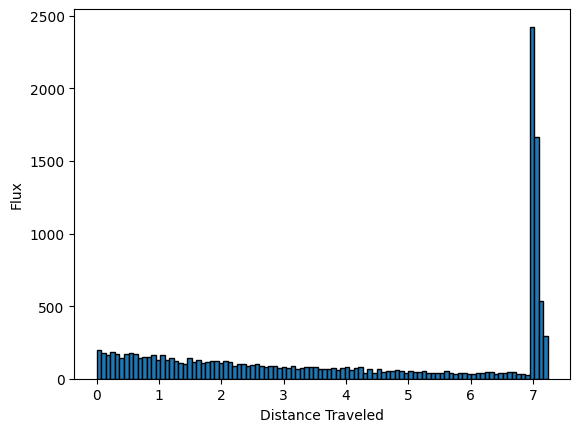

4.204129443521452


In [16]:
# histogram
data = np.array([])
for i in range(samples):
  theta, phi = dir_from_γ_energy_range((2.5,20))
  if theta >= 0:
    dir = sph_car(theta, phi)
    en,ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
    if en is not None and ex is not None:
      data = np.append(data, np.linalg.norm(en - ex))

plt.hist(data, bins=bins, edgecolor='black')

plt.xlabel('Distance Traveled')
plt.ylabel('Flux')

plt.show()
print(np.mean(data))

In [37]:
# UI rendering
target_box = box(width, height, depth, (0, 0, depth / 2 + origin), 'red')

z_ray = ray(np.array([0, 0, 0]), sph_car(0, 0), 1, 'red')
y_ray = ray(np.array([0, 0, 0]), sph_car(np.pi/2, np.pi/2), 1, 'green')
x_ray = ray(np.array([0, 0, 0]), sph_car(0, np.pi/2), 1, 'blue')

rayy = ray(np.array([0, 0, 0]), sph_car(-2.8, 0.2), 1000, 'yellow')

origin_point = point([0, 0, 0], 'white', 4)

scene = Scene(children=[target_box, origin_point, x_ray, y_ray, z_ray, rayy])
scene.background = '#141414'

lights = [
    DirectionalLight(color='white', intensity=3, position=[0, 200, 0]),
    DirectionalLight(color='white', intensity=3, position=[100, 200, 100]),
    DirectionalLight(color='white', intensity=3, position=[-100, -200, -100])
]
for light in lights:
    scene.add(light)

camera = PerspectiveCamera(position=[10, 10, 10], up=[0, 1, 0], children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

display(Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], antialias=True, width=800, height=600))

/usr/local/lib/python3.10/dist-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_3f56e85a-047e-41c6-806d-bb66f0a28aba'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_89bbc98c-487f-4c50-a396-91bc185c5f57'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_2263e928-dafb-4285-a6bf-435816ac640c'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_d873678c-d68d-4336-839c-685340d9ed2a'.